<h1><center>PAMSI AI</center></h1>
<h2><center>CATS vs DOGS <br> Final battle! </center></h2>
<h4><center>Produced by: <br> Marcin Karasiewicz <br> Rafał Kowalski</center></h4>

![title](reports/bg.jpg)

The goal of this project is to create a neural network able to recognize whether the picture is a dog or a cat. The network will be built using the Keras framework with the Tensorflow backend. The assumed goal is 90% of effectiveness. <br>

We decided to build the model in a multistage manner. These are the next steps to build a neural network:

1. Bottleneck features
2. Top model
3. Fine-tuning

## Imports

### Imports necessary to build a network model

In [4]:
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os.path

### Imports necessary to presentation of results

In [5]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import random

## Constans

In [6]:
BATCH_SIZE = 50
EPOCHS = 20

TRAIN_SAMPLES = 20000
VALID_SAMPLES = 5000

IMG_WIDTH = 224
IMG_HEIGHT = 224

INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

TRAIN_DATA_DIR = 'data/train_files'
VALID_DATA_DIR = 'data/validation_files'

## BOTTLENECK FEATURES

We will use the VGG16 architecture, pre-trained on the ImageNet dataset --a model previously featured on this blog. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem.

![title](reports/BT.png)

class_mode=None -> this means our generator will only yield batches of data, no labels <br>
shuffle=False   -> data will be in order, so all first 12500 images will be cats, then 12500 dogs

In [7]:
if os.path.isfile('models/bottleneck_features_train.npy'):
    print("bottleneck features exists")
else:
    bottleneck_model = VGG16(include_top=False, weights='imagenet')

    bottleneck_train_datagen = ImageDataGenerator(rescale=1./255)

    bottleneck_train_generator = bottleneck_train_datagen.flow_from_directory(
        'data/train_files',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False)

    bottleneck_features_train = bottleneck_model.predict_generator(
        bottleneck_train_generator,
        steps=TRAIN_SAMPLES // BATCH_SIZE,
        verbose=1)

    np.save('models/bottleneck_features_train.npy', bottleneck_features_train)

bottleneck features exists


In [8]:
if os.path.isfile('models/bottleneck_features_validation.npy'):
    print("bottleneck features exists")
else:
    bottleneck_model = VGG16(include_top=False, weights='imagenet')

    bottleneck_validation_datagen = ImageDataGenerator(rescale=1./255)

    bottleneck_validation_generator = bottleneck_train_datagen.flow_from_directory(
        'data/validation_files',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False)

    bottleneck_features_validation = bottleneck_model.predict_generator(
        bottleneck_validation_generator,
        steps=VALID_SAMPLES // BATCH_SIZE,
        verbose=1)

    np.save('models/bottleneck_features_validation.npy',bottleneck_features_validation)

bottleneck features exists


## TOP MODEL

### Training

In [9]:
if os.path.isfile('models/top_model_weights.h5'):
    print("top_model_weights.h5 exists")
else:
    train_data = np.load('models/bottleneck_features_train.npy')
    train_labels = [0] * (TRAIN_SAMPLES // 2) + [1] * (TRAIN_SAMPLES // 2)

    validation_data = np.load('models/bottleneck_features_validation.npy')
    validation_labels = [0] * (VALID_SAMPLES // 2) + [1] * (VALID_SAMPLES // 2)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=train_data.shape[1:]))
    top_model.add(Dense(512, activation='relu'))
    top_model.add(Dropout(0.55))
    top_model.add(Dense(512, activation='relu'))
    top_model.add(Dropout(0.55))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = top_model.fit(train_data, train_labels,
                  epochs=10,
                  batch_size=BATCH_SIZE,
                  validation_data=(validation_data, validation_labels))

    top_model.save_weights('models/top_model_weights.h5')

top_model_weights.h5 exists


### History for accuracy & loss

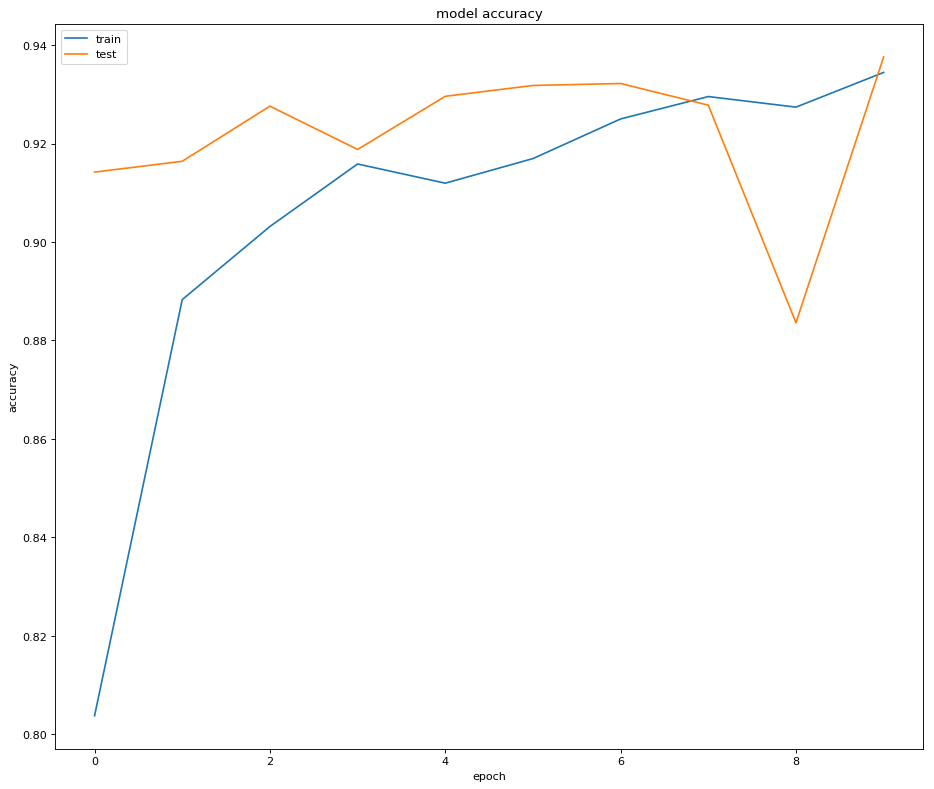

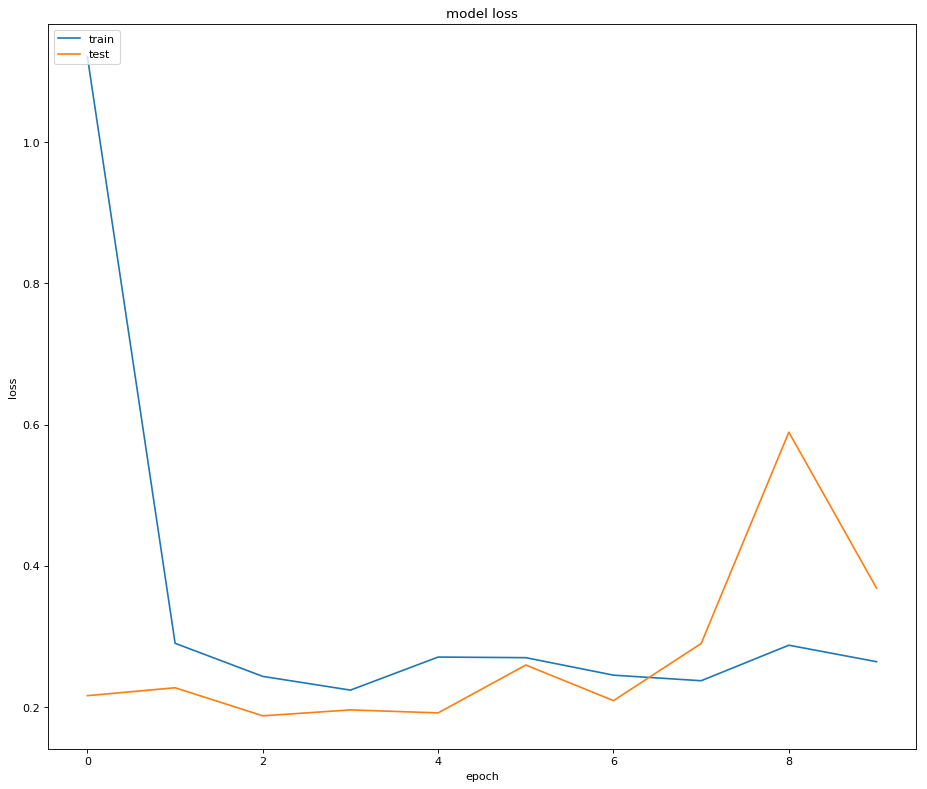

In [17]:
# summarize history for accuracy
plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## FINE-TUNING

![title](reports/FT.png)

In [10]:
vgg16_model = VGG16(include_top=False, 
                    weights='imagenet',
                    input_shape=INPUT_SHAPE)

top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:], name='flatten'))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.55))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.55))
top_model.add(Dense(1, activation='sigmoid', name='pred'))

top_model.load_weights('models/top_model_weights.h5')

model = Model(inputs=vgg16_model.input, outputs=top_model(vgg16_model.output))


for layer in model.layers[:25]:
    layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [10]:
if os.path.isfile('./models/cat_dog_final.h5'):
    print("cat_dog_final.h5 exists")
else:
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
        )

    train_generator = train_datagen.flow_from_directory(
        directory=TRAIN_DATA_DIR,
        target_size=(IMG_WIDTH,IMG_HEIGHT),
        class_mode='binary',
        batch_size=BATCH_SIZE)

    validation_datagen = ImageDataGenerator(
        rescale = 1./255)

    validation_generator = validation_datagen.flow_from_directory(
        directory=VALID_DATA_DIR,
        target_size=(IMG_WIDTH,IMG_HEIGHT),
        class_mode='binary',
        batch_size=BATCH_SIZE)

    model.fit_generator(
        train_generator,
        steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=VALID_SAMPLES // BATCH_SIZE)

    model.save_weights('./models/cat_dog_final.h5')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/1
400/400 [==============================] - 2569s 6s/step - loss: 0.7818 - acc: 0.8460 - val_loss: 0.3685 - val_acc: 0.9376


I am 100.00% sure this is a Doggo


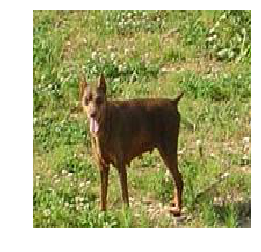

I am 100.00% sure this is a Catto


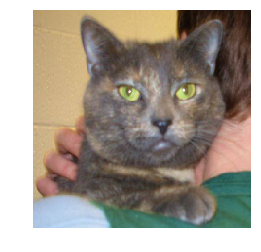

I am 100.00% sure this is a Doggo


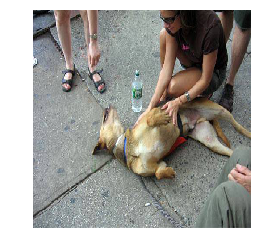

I am 100.00% sure this is a Doggo


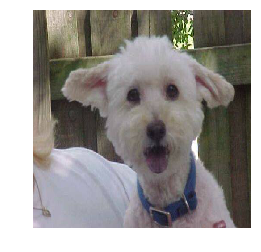

I am 100.00% sure this is a Doggo


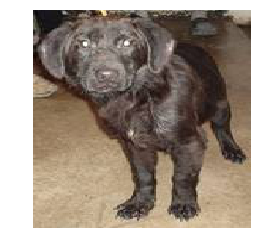

In [11]:
if os.path.isfile('./models/cat_dog_final.h5'):
    model.load_weights('./models/cat_dog_final.h5')
    
    my_randoms = np.random.randint(10000, size=5)
    
    for i in my_randoms:
        
        name = "./data/test_files/test1/"+str(i)+".jpg"
        
        img = image.load_img(name, target_size=(224, 224))
        img_tensor = image.img_to_array(img)                    
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor /= 255.  
        
        pred = model.predict(img_tensor)
        
        if pred[0][0] > 0.5:
            print('I am {:.2%} sure this is a Doggo'.format(pred[0][0]))
        else:
            print('I am {:.2%} sure this is a Catto'.format(1-pred[0][0]))
            
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()